# LocusRegression Simulation Studies

This tutorial covers how to construct synthetic datasets, then train and evaluate LocusRegression models using those datasets. First, some imports: 

In [29]:
import numpy as np

### Transition matrix

To simulate some data according to the generative model proposed by LocusRegression, we first need to define ground-truth genomic states for each locus in a hypothetical genome. We assign states by sampling a chain from a predefined Markov transition matrix. The transition matrix should be of size $(N_{states}, N_{states})$, and have rowsums of 1.

In [30]:
transition_matrix = np.array([
    [0.99, 0.005, 0.005],
    [0.0, 0.97, 0.03],
    [0.015, 0.015, 0.97]
])

Each of these states will correspond with changes to some simluated genomic correlate. Next we define the distribution of each correlate. Correlates are simulated using the model:

$X_{s,\ell} \sim \textrm{Normal}(\mu \cdot \delta({\textrm{state}(\ell) - s)}, \sigma^2)$

where the correlate associated with state $s$ is centered at $\mu$ for loci in that state, and $0$ otherwise. These correlates are stardardized before modeling. We provide a matrix of $\mu$'s and $\sigma$'s, each with shape $(N_{states})$.

In [31]:
signal_means = np.array([1.,1.,1.])
signal_stds = np.array([0.3, 0.25, 0.5])

### Trinucleotide differences

To finish setting up the properties of each genomic state, we define state-specific priors over the trinucleotide content of loci in that state. The trinucleotide content of each locus is subsequently sampled from a Dirichlet distribution with the corresponding prior. The priors matrix must be of shape $(N_{states}, 32)$. Here, I provide uniform priors for each state with varying degrees of noise/sparsity:

In [32]:
trinuc_priors = np.array([
    np.ones(32) * 5.,
    np.ones(32) * 20,
    np.ones(32) * 10,
])

### $\beta$ matrix

Lastly, we need to relate those states and correlates to processes. For this, we define a $\beta$ matrix of size $(N_{processes}, N_{states})$, which relates how each process associates with genomic correlates:

In [33]:
beta_matrix = np.array([
    [1,-0.5,0],
    [-0.5,1,-0.5],
    [-0.5,-0.5,1],
    [1,-1,1],
    [0.,1.,1],
])

### Generating a simulated dataset

Now, we can use these generative parameters to construct a dataset. We provide the structured information outline above, along with parameters for:

* `n_cells` : the number of samples (called "cells" here in homage to ssDNA-seq)
* `log_mean_mutations`, `log_std_mutations`: parameters of the $\mathrm{LogNormal}$ distribution from which the number of mutations per cells are drawn
* `pi_prior` : prior for the dirichlet distribution from which compositions over processes are drawn for each cell
* `n_loci` : the number of genomic bins. 10Kb bins over the entire genome gives ~250K regions after filtering repetitive elements, centromeres, etc.
* `seed` : reproducably produces the same simulated dataset

And finally, we associate each process with a known signature from the COSMIC catalogue:

In [34]:
exposures = np.random.RandomState(0).choice([10,100,1000,10000], p = [0.1, 0.3, 0.3, 0.3], size = 250000)[None,:]

In [35]:
simulation_params = dict(
    state_transition_matrix = transition_matrix,
    beta_matrix = beta_matrix,
    trinucleotide_priors = trinuc_priors,
    signal_means= signal_means,
    n_cells = 100,
    log_mean_mutations = 6,
    log_std_mutations = 0.5, 
    pi_prior = 1,
    n_loci = 250000,
    cosmic_sigs=['SBS1','SBS93','SBS3','SBS5','SBS2'],
    exposures = exposures,
)

Save this configuration dictionary as a pickle file:

In [36]:
!mkdir -p data

In [37]:
import pickle

with open('data/simulation_params_1.pkl','wb') as f:
    pickle.dump({**simulation_params, 'seed' : 10, 'corpus_name' : 'corpus1'}, f)

with open('data/simulation_params_2.pkl','wb') as f:
    pickle.dump({**simulation_params, 'seed' : 20, 'corpus_name' : 'corpus2',}, f)

Then run the `locusregression` command to sample a synthetic dataset.

In [38]:
!locusregression simulate --config data/simulation_params_1.pkl --prefix "data/tutorial.sim1."

Generating samples: 100%|█████████████████████████████████████████| 100/100 [00:46<00:00,  2.15it/s]


In [ ]:

!locusregression simulate --config data/simulation_params_2.pkl --prefix "data/tutorial.sim2."

## Convergence analysis

In [1]:
import locusregression
import numpy as np
import logging
import seaborn as sns
logging.basicConfig(level=logging.INFO)
locusregression.logger.setLevel(logging.INFO)

corpus = locusregression.load_corpus('data/tutorial.sim1.corpus.h5')

/Users/allen/miniconda3/envs/locusregression/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = locusregression.LocusRegressor(
    n_components=5,
    empirical_bayes=True,
    fix_signatures=['SBS1','SBS93','SBS3','SBS5','SBS2'],
    eval_every=1,
    batch_size=1000,
    locus_subsample=1.,
    num_epochs=300,
).fit(
    corpus,
)
model.save('data/tutorial.model.pth')

INFO: LocusRegressor:Initializing model ...
INFO: LocusRegressor:Found feature group: feature0, feature1, feature2
INFO: LocusRegressor:Training model ...
INFO: LocusRegressor:E-step - time: 0.20s. 
INFO: LocusRegressor:M-step - time: 0.35s. 
INFO: LocusRegressor:Calculating bound - time: 0.02s. 
INFO: LocusRegressor: [  1/301] | Time: 0.72s. | Perplexity: 7969403.78, improvement: 0.00       
INFO: LocusRegressor:E-step - time: 0.15s. 
INFO: LocusRegressor:M-step - time: 0.26s. 
INFO: LocusRegressor:Calculating bound - time: 0.02s. 
INFO: LocusRegressor: [  2/301] | Time: 0.57s. | Perplexity: 7127217.45, improvement: 842186.33  
INFO: LocusRegressor:E-step - time: 0.12s. 
INFO: LocusRegressor:M-step - time: 0.26s. 
INFO: LocusRegressor:Calculating bound - time: 0.01s. 
INFO: LocusRegressor: [  3/301] | Time: 0.53s. | Perplexity: 6891613.79, improvement: 235603.66  
INFO: LocusRegressor:E-step - time: 0.12s. 
INFO: LocusRegressor:M-step - time: 0.23s. 
INFO: LocusRegressor:Calculating b

array([<Axes: ylabel='SBS1'>, <Axes: ylabel='SBS93'>,
       <Axes: ylabel='SBS3'>, <Axes: ylabel='SBS5'>,
       <Axes: ylabel='SBS2'>], dtype=object)

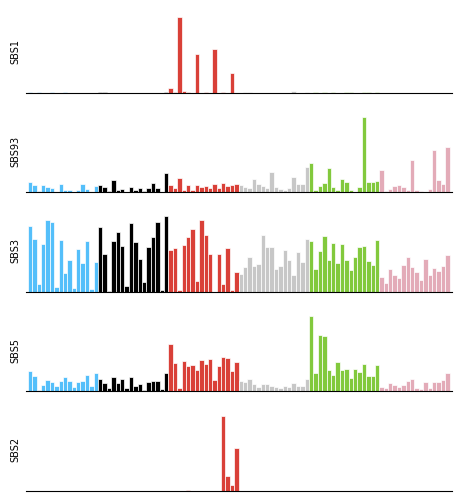

In [4]:
model.plot_summary()

In [1]:
import locusregression
from locusregression.simulation.simulation import SimulatedCorpus
import logging
import seaborn as sns
logging.basicConfig(level=logging.INFO)
locusregression.logger.setLevel(logging.INFO)

/Users/allen/miniconda3/envs/locusregression/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model = locusregression.load_model('data/tutorial.model.pth')
resampled_corpus = SimulatedCorpus.from_model(
    model.model_state,
    model.corpus_states['corpus1'],
)
locusregression.save_corpus(resampled_corpus, 'data/tutorial.sim1.resampled.corpus.h5')

In [13]:
!locusregression simulate-from-model data/tutorial.model.pth -d data/tutorial.sim1.corpus.h5 -o data/tutorial.sim1.resampled.h5

Generating samples: 100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


In [14]:
resampled_corpus = locusregression.stream_corpus('data/tutorial.sim1.resampled.corpus.h5')

In [15]:
resampled_model = locusregression.LocusRegressor(
    n_components=5,
    empirical_bayes=True,
    fix_signatures=['SBS1','SBS93','SBS3','SBS5','SBS2'],
    eval_every=1,
    batch_size=1000,
    locus_subsample=1.,
    num_epochs=300,
).fit(
    resampled_corpus,
)

INFO: LocusRegressor:Initializing model ...
INFO: LocusRegressor:Found feature group: feature0, feature1, feature2
INFO: LocusRegressor:Training model ...
INFO: LocusRegressor:E-step - time: 0.24s. 
INFO: LocusRegressor:M-step - time: 0.35s. 
INFO: LocusRegressor:Calculating bound - time: 0.06s. 
INFO: LocusRegressor: [  1/301] | Time: 0.74s. | Perplexity: 6827560.76, improvement: 0.00       
INFO: LocusRegressor:E-step - time: 0.20s. 
INFO: LocusRegressor:M-step - time: 0.26s. 
INFO: LocusRegressor:Calculating bound - time: 0.06s. 
INFO: LocusRegressor: [  2/301] | Time: 0.60s. | Perplexity: 6197317.90, improvement: 630242.86  
INFO: LocusRegressor:E-step - time: 0.18s. 
INFO: LocusRegressor:M-step - time: 0.27s. 
INFO: LocusRegressor:Calculating bound - time: 0.06s. 
INFO: LocusRegressor: [  3/301] | Time: 0.59s. | Perplexity: 5996029.31, improvement: 201288.59  
INFO: LocusRegressor:E-step - time: 0.16s. 
INFO: LocusRegressor:M-step - time: 0.24s. 
INFO: LocusRegressor:Calculating b

array([<Axes: ylabel='SBS1'>, <Axes: ylabel='SBS93'>,
       <Axes: ylabel='SBS3'>, <Axes: ylabel='SBS5'>,
       <Axes: ylabel='SBS2'>], dtype=object)

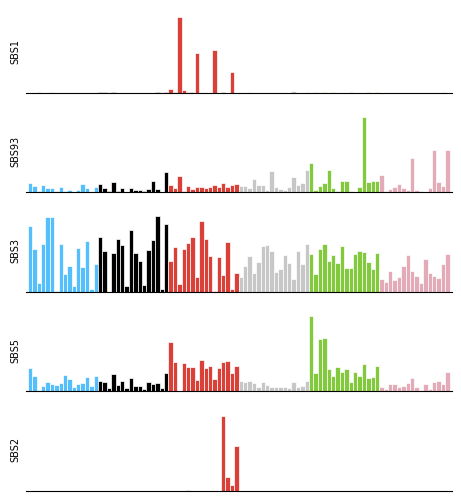

In [16]:
resampled_model.plot_summary()

The simulation method outputs the same "corpus" object which is used for real data, so we can treat real and simulated data exactly the same. Additionally, the simulation outputs `parameters`, which are the ground truth attributes of the dataset which governed the generative process.

## Modeling the dataset

You can either tune a model (most realistic):

In [ ]:
!locusregression create-study \
    --corpuses data/tutorial.corpus.h5 \
    -min 3 -max 10 --tune-subsample \
    --study-name tutorial.1

[I 2023-10-29 16:28:46,101] Using an existing study with name 'tutorial.1' instead of creating a new one.


In [ ]:
!for i in {1..10}; do locusregression run-trial tutorial.1 -i 20 > data/$i.log 2>&1 &; done

or just provide the number of topics and get started:

In [ ]:
!locusregression model-train \
                 --corpuses data/tutorial.sim1.corpus.h5 data/tutorial.sim2.corpus.h5 \
                 --n-components=5 \
                 -v --eval-every 1 \
                 -sub 0.125 --batch-size 32 \
                 -o data/tutorial_model_no-tuning.pkl \
                 --num-epochs 60

INFO:LocusRegressor:  Epoch 2   complete. | Elapsed time: 0.48 seconds. | Bound: -1125859.61, improvement: 9354.09    
INFO:LocusRegressor:  Epoch 3   complete. | Elapsed time: 0.49 seconds. | Bound: -1117220.10, improvement: 8639.51    
INFO:LocusRegressor:  Epoch 4   complete. | Elapsed time: 0.45 seconds. | Bound: -1109812.86, improvement: 7407.24    
INFO:LocusRegressor:  Epoch 5   complete. | Elapsed time: 0.49 seconds. | Bound: -1105407.40, improvement: 4405.46    
INFO:LocusRegressor:  Epoch 6   complete. | Elapsed time: 0.50 seconds. | Bound: -1101930.08, improvement: 3477.32    
INFO:LocusRegressor:  Epoch 7   complete. | Elapsed time: 0.44 seconds. | Bound: -1099912.13, improvement: 2017.95    
INFO:LocusRegressor:  Epoch 8   complete. | Elapsed time: 0.46 seconds. | Bound: -1098162.69, improvement: 1749.44    
INFO:LocusRegressor:  Epoch 9   complete. | Elapsed time: 0.44 seconds. | Bound: -1096705.71, improvement: 1456.98    
INFO:LocusRegressor:  Epoch 10  complete. | Elap

If you went with the tuning option, study and plot the model scores versus the number of topics used:

In [ ]:
from optuna.visualization.matplotlib import *
from locusregression import load_study
from IPython.display import Image

study, dataset, study_attrs = load_study('tutorial.1')

/Users/allenwlynch/miniconda3/envs/locusregression/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: title={'center': 'Slice Plot'}, xlabel='n_components', ylabel='Objective Value'>

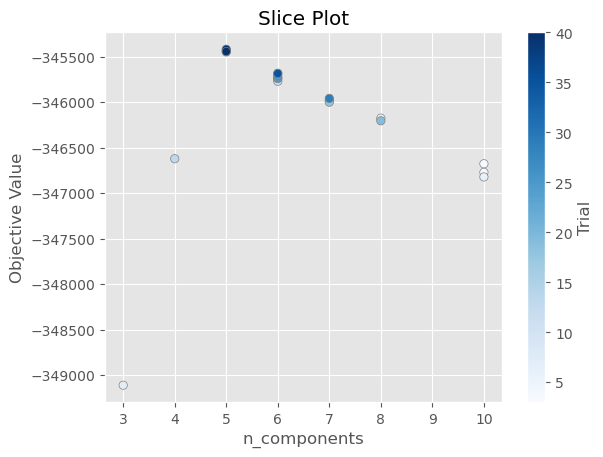

In [ ]:
plot_slice(study, params = ['n_components'])

The best model had five topics, just like the simulation! The next command retrains a model on the whole dataset with the best hyperparameters found in the tuning stage. Instead of retraining the best model (by default), you can provide the trial number of a model you wish to train instead.

In [ ]:
!locusregression retrain tutorial.1 -o data/tutorial_model.pkl

Training model with params:
	n_components: 5
	locus_subsample: 0.125
	seed: 95237200
	tau: 1
	kappa: 0.7
	batch_size: 70
INFO:LocusRegressor:  Epoch 40  complete. | Elapsed time: 0.47 seconds. | Bound: -543212.25, improvement: 3196.33    
INFO:LocusRegressor:  Epoch 60  complete. | Elapsed time: 0.47 seconds. | Bound: -542412.70, improvement: 799.55     
INFO:LocusRegressor:  Epoch 80  complete. | Elapsed time: 0.52 seconds. | Bound: -542145.87, improvement: 266.83     
INFO:LocusRegressor:  Epoch 100 complete. | Elapsed time: 0.49 seconds. | Bound: -542026.64, improvement: 119.23     
INFO:LocusRegressor:  Epoch 120 complete. | Elapsed time: 0.49 seconds. | Bound: -541961.65, improvement: 64.99      
INFO:LocusRegressor:  Epoch 140 complete. | Elapsed time: 0.57 seconds. | Bound: -541921.87, improvement: 39.78      
INFO:LocusRegressor:  Epoch 160 complete. | Elapsed time: 0.52 seconds. | Bound: -541894.85, improvement: 27.01      
INFO:LocusRegressor:  Epoch 180 complete. | Elapsed t

# Evaluation

I have some crude metrics implemented for evaluating the solution against the generative parameters. `coef_l1_distance` evaluates the mean $\mathrm{L1}$ distance between the the model's inferred $\beta$'s and the closest match with amongst the ground truth $\beta$'s. Next, the `signature_cosine_sim` is the average cosine similarity between each signature found by the model and the closest match signature in the ground thruth:

In [ ]:
!locusregression eval-sim --model data/tutorial_model.pkl -sim data/tutorial.generative_params.pkl

coef_L1_dist	signature_cos_sim
0.08843849701647612	0.996320025870524


This model is very close to perfect. We can access important information from the trained model using the following series of commands.
First, to get the per-sample exposures to each component, use "model-predict", which saves a csv file with sample vcf filepaths and their normalized exposure to each component:

In [ ]:
!locusregression model-predict data/tutorial_model.pkl \
                        -d data/tutorial.corpus.h5 \
                        > data/tutorial.predictions.csv
!head -n3 data/tutorial.predictions.csv

,Component 0,Component 1,Component 2,Component 3,Component 4
0,0.30069280253600184,0.47184855580497875,0.03721007756334462,0.11697302132840792,0.07327554276726678
1,0.12299368849495783,0.09825385839102703,0.2812218489368849,0.04511279990053025,0.4524178042766001


The next command, "model-summary", plots the association weights and signatures of each component:

In [ ]:
!locusregression model-plot-summary data/tutorial_model_no-tuning.pkl -o data/model_summary.png

In [ ]:
from IPython.display import Image

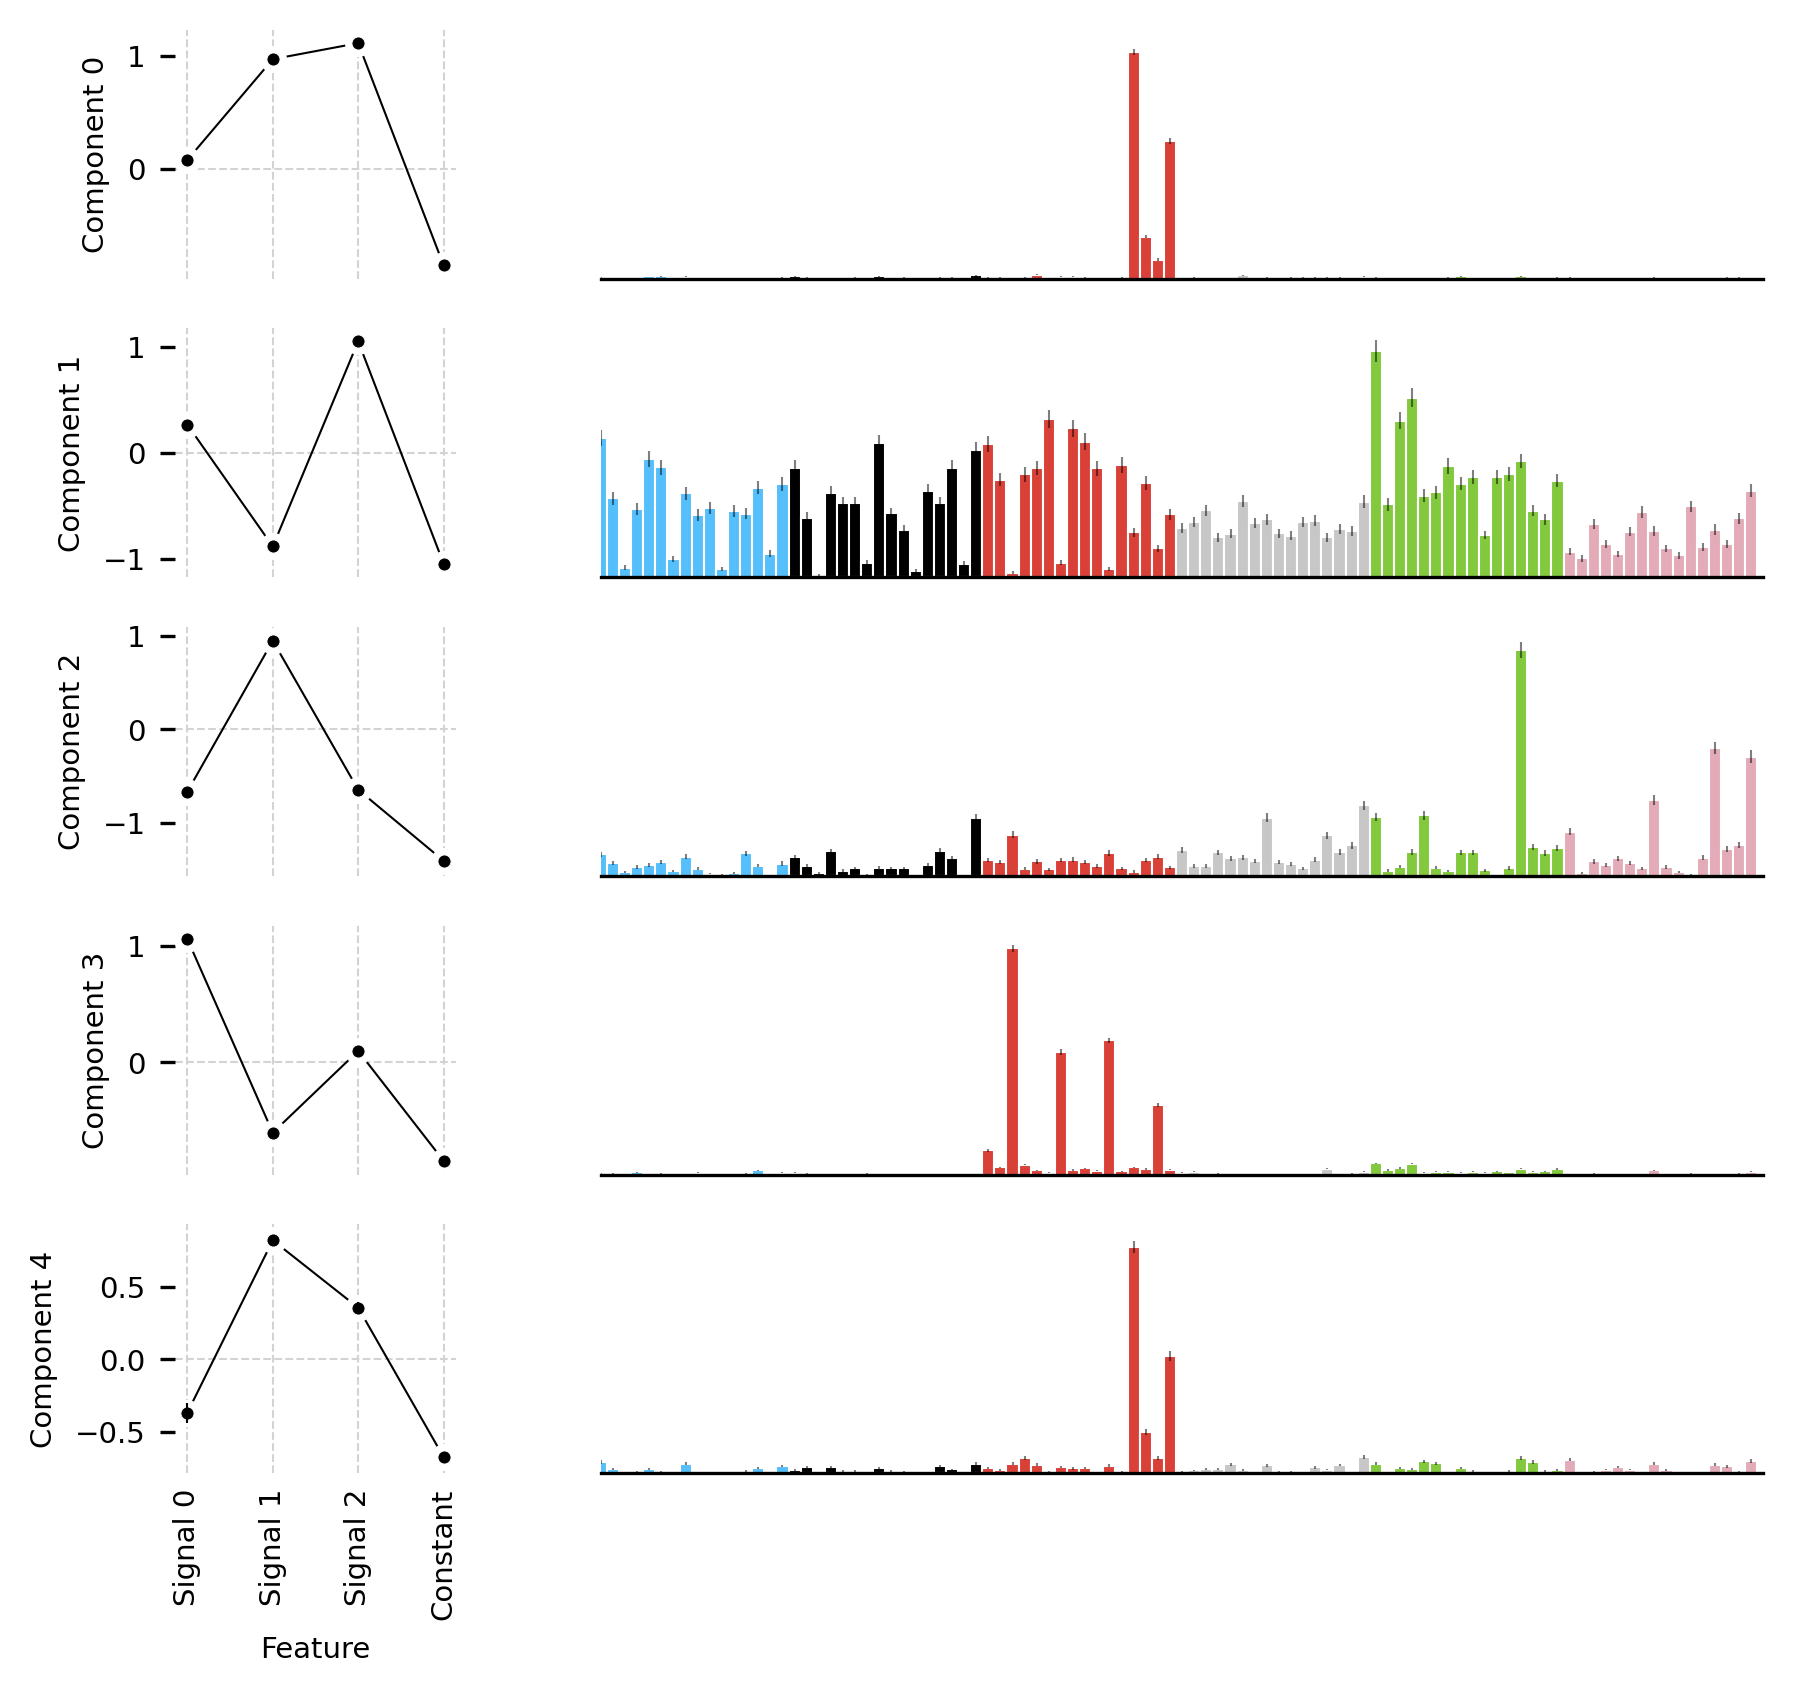

In [ ]:
Image(filename='data/model_summary.png', width = 700)

"model-compare-coefs" clusters and plots a multidimensional comparison of all of the associations for each component. Try different values of "--cluster-distance/-dist" to control cluster coarseness. I find that many signatures have similar associations, so outliers are more interesting. By default, this plot colors the most common cluster grey so that outliers can be easily distinguished. 

In [ ]:
!locusregression model-plot-coefs  data/tutorial_model.pkl \
                    -o data/model_compare_coefs.png \
                    -dist 1.5

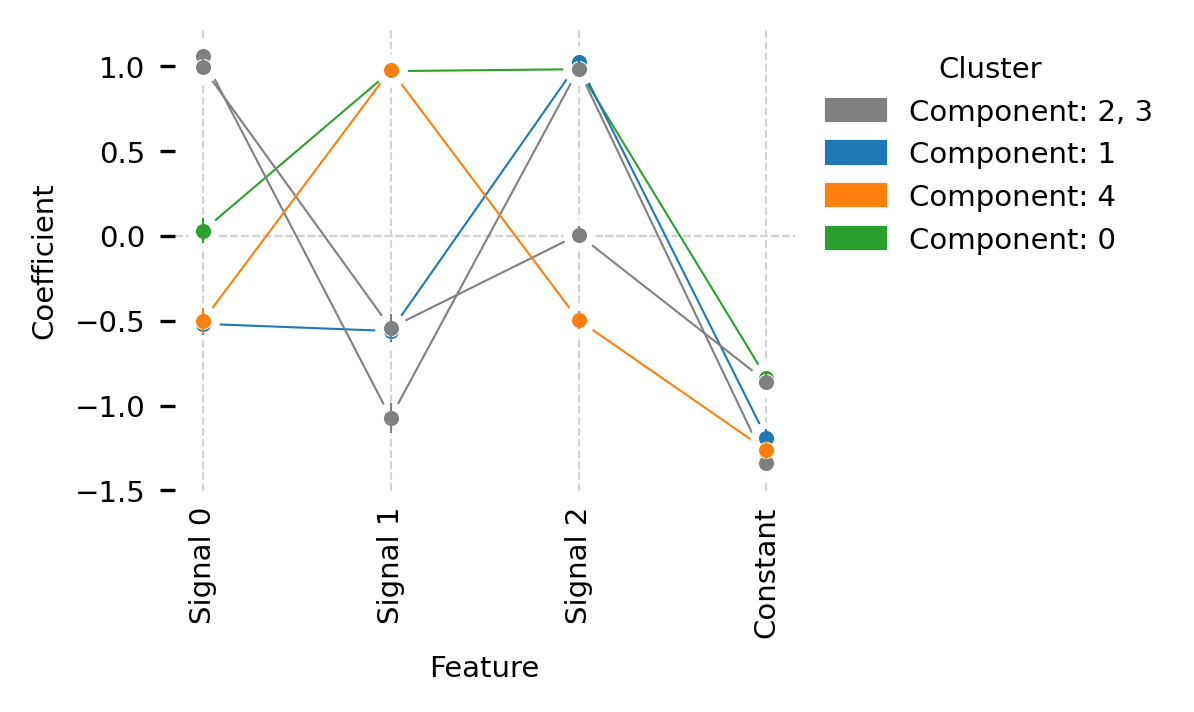

In [ ]:
Image(filename='data/model_compare_coefs.png', width = 650)

In [ ]:
!locusregression model-save-signatures data/tutorial_model.pkl -o data/tutorial_model_signatures.csv
!locusregression model-save-associations data/tutorial_model.pkl -o data/tutorial_model_associations.csv

In [ ]:
import seaborn as sns

In [1]:
from locusregression import *
import logging
import numpy as np
logging.basicConfig(level=logging.INFO)
logger.setLevel(logging.INFO)

corpus1 = stream_corpus('data/tutorial.sim1.corpus.h5')
corpus1.X_matrix = corpus1.X_matrix[:3,:]
corpus2 = stream_corpus('data/tutorial.sim2.corpus.h5')
corpus2.X_matrix = corpus2.X_matrix[:3,:]

meta = MetaCorpus(corpus1, corpus2)

model_args = dict(
    n_components=5, 
    num_epochs=25,
    batch_size=None, 
    locus_subsample=1,
    eval_every=1,
    quiet=False,
    tau = 16,
    pi_prior=1,
    fix_signatures=['SBS1','SBS2','SBS3','SBS5','SBS93'],
    empirical_bayes=True,
    begin_prior_updates=0,
)

gbtmodel = GBTRegressor(**model_args).fit(
    meta
)
#linmodel = LocusRegressor(**model_args).fit(corpus1)

/Users/allenwlynch/miniconda3/envs/locusregression/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: LocusRegressor:Initializing model ...
INFO: LocusRegressor:Training model ...
INFO: LocusRegressor: [  1/26] | Time: 10.74s. | Perplexity: 229020.65 , improvement: 0.00       
INFO: LocusRegressor: [  2/26] | Time: 8.27s. | Perplexity: 219316.33 , improvement: -9704.33   
INFO: LocusRegressor: [  3/26] | Time: 10.98s. | Perplexity: 214008.66 , improvement: -5307.67   
INFO: LocusRegressor: [  4/26] | Time: 10.07s. | Perplexity: 211759.28 , improvement: -2249.38   
INFO: LocusRegressor: [  5/26] | Time: 9.16s. | Perplexity: 210506.47 , improvement: -1252.81   
INFO: LocusRegressor: [  6/26] | Time: 9.19s. | Perplexity: 209486.54 , improvement: -1019.93   
INFO: LocusRegressor: [  7/26] | Time: 8.52s. |

In [3]:
from scipy.special import xlogy
import numpy as np

def _logp_obj(model, X, y, ):
    split = len(X)//2
    g_hat = model.predict(X)
    g1 = g_hat[:split]; g2 = g_hat[split:]
    G1 = g1.sum(); G2 = g2.sum()
    y1 = y[:split]; y2 = y[split:]
    return -xlogy(y1, g1/G1).sum() - xlogy(y2, g2/G2).sum()

def _deviance(model, X, y):
    split = len(X)//2
    y1 = y[:split]; y2 = y[split:]
    return -2*(
        -xlogy(y1, y1/y1.sum()).sum() - xlogy(y2, y2/y2.sum()).sum() - _logp_obj(model, X, y)
    )

def r2(model, X, y, sample_weight=None):
    
    class InterceptModel:
        def __init__(self):
            pass
        def predict(self, X):
            return np.ones(len(X))
        
    return 1 - _deviance(model, X, y) / _deviance(InterceptModel(), X, y)

In [4]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import PoissonRegressor

In [5]:
sstats, _ = gbtmodel._inference(
    locus_subsample_rate=1, batch_subsample_rate=1,learning_rate=1, 
    corpus = meta,
    model_state= gbtmodel.model_state,
    corpus_states = gbtmodel.corpus_states, 
    gamma = gbtmodel._gamma
)

X, y, sample_weight, raw_predictions, design_matrix = next( gbtmodel.model_state._get_features(sstats) )

In [6]:
np.savez('data/features.npy', 
        X = X, 
        y = y, 
        sample_weight = sample_weight, 
        raw_predictions = raw_predictions, 
        design_matrix = design_matrix.toarray()
    )

### Testing new GBT model

In [7]:
from scipy.special import logsumexp, xlogy
import numpy as np
from scipy.sparse import csc_matrix
from locusregression.model.gbt._gbt_modelstate import _get_model_fn
from locusregression.model.gbt._hist_gbt import _multinomial_loss
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import PoissonRegressor

z = np.load('data/features.npy.npz')
X = z['X']; y = z['y']; sample_weight = z['sample_weight']; raw_predictions = z['raw_predictions']
design_matrix = csc_matrix(z['design_matrix'])

def _logp_obj(model, X, y, ):
    split = len(X)//2
    g_hat = model.predict(X)
    g1 = g_hat[:split]; g2 = g_hat[split:]
    G1 = g1.sum(); G2 = g2.sum()
    y1 = y[:split]; y2 = y[split:]
    return -xlogy(y1, g1/G1).sum() - xlogy(y2, g2/G2).sum()

X_ = np.hstack([X, design_matrix.toarray()])
linreg = PoissonRegressor(alpha = 0, fit_intercept=False, solver='newton-cholesky')
linmodel = linreg.fit(X_, y/sample_weight, sample_weight)

#r2(linmodel, X_, y), _deviance(linmodel, X_, y)
_logp_obj(linmodel, X_, y), _multinomial_loss(
        y_true=y,
        raw_prediction= np.log(linmodel.predict(X_)),
        design_matrix=design_matrix,
        sample_weight=None,
        )*len(y)

(277249.1909502031, -277249.19095020293)

In [8]:
gbtreg = gbtmodel.model_state.rate_models[0]
gbtreg.max_iter = 200
#gbtreg = _get_model_fn(design_matrix, X)

'''gbtreg = HistGradientBoostingRegressor(
    loss = 'poisson',
    learning_rate = 0.1,
    max_iter = 100,
    warm_start=True,
    #scoring=r2,
    verbose=True,
)
'''
gbtreg.verbose=True
gbtreg.fit(
    X, y, sample_weight=sample_weight,
    raw_predictions=np.zeros_like(raw_predictions).reshape((-1,1)),
    design_matrix=design_matrix,
)

Binning 0.010 GB of training data: 0.018 s
Binning 0.002 GB of validation data: 0.016 s
Fitting gradient boosted rounds:
[76/200] 1 tree, 31 leaves, max depth = 5, train loss: 0.56597, val loss: 0.49728, in 0.063s
[77/200] 1 tree, 31 leaves, max depth = 5, train loss: 0.56197, val loss: 0.49330, in 0.059s
[78/200] 1 tree, 31 leaves, max depth = 5, train loss: 0.55897, val loss: 0.49031, in 0.060s
[79/200] 1 tree, 31 leaves, max depth = 5, train loss: 0.55662, val loss: 0.48795, in 0.060s
[80/200] 1 tree, 31 leaves, max depth = 5, train loss: 0.55471, val loss: 0.48606, in 0.059s
[81/200] 1 tree, 31 leaves, max depth = 5, train loss: 0.55315, val loss: 0.48450, in 0.062s
[82/200] 1 tree, 31 leaves, max depth = 5, train loss: 0.55185, val loss: 0.48321, in 0.061s
[83/200] 1 tree, 31 leaves, max depth = 5, train loss: 0.55076, val loss: 0.48214, in 0.062s
[84/200] 1 tree, 31 leaves, max depth = 5, train loss: 0.54984, val loss: 0.48123, in 0.064s
[85/200] 1 tree, 31 leaves, max depth = 5,

CustomHistGradientBooster(early_stopping=True, loss='poisson', max_depth=5,
                          max_iter=200,
                          random_state=RandomState(MT19937) at 0x17ED2CC40,
                          validation_fraction=0.2, verbose=True,
                          warm_start=True)

In [9]:
import seaborn as sns

<Axes: >

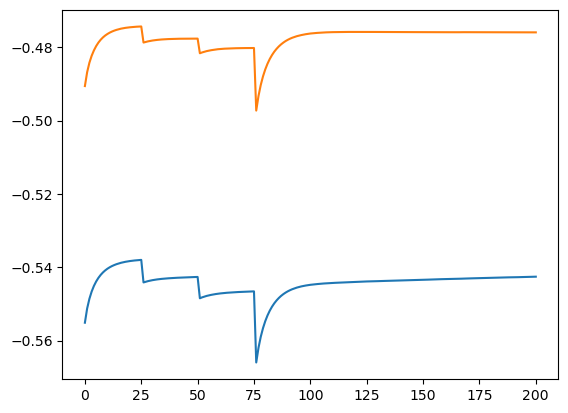

In [10]:
sns.lineplot(
    gbtreg.train_score_
)
sns.lineplot(
    gbtreg.validation_score_
)

In [11]:
_logp_obj(gbtreg, X, y), _logp_obj(linmodel, X_, y)

(278891.1999364266, 277249.1909502031)

In [12]:
import seaborn as sns

In [16]:
gbtmodel.model_state.rate_models[1].n_iter_

75

In [17]:
gbtmodel.model_state.predict_from = [75]*5

In [20]:
gbtmodel.corpus_states['corpus2'].update_mutation_rate(gbtmodel.model_state)

In [27]:
erg = np.concatenate([
    np.exp(gbtmodel.corpus_states['corpus1']._logmu[0,:]), np.exp(gbtmodel.corpus_states['corpus2']._logmu[0,:])
])

<Axes: >

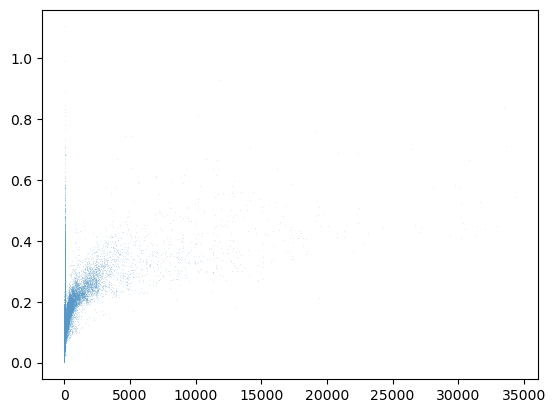

In [30]:
sns.scatterplot(
    x = erg, #gbtreg.predict(X),
    y = linmodel.predict(X_),
    s = 0.1,
    #hue = [i > 250000 for i in range(len(y))],
)

In [12]:
from scipy.stats import multinomial
import numpy as np
from scipy.special import xlogy

In [243]:
rs = np.random.RandomState(0)
X = rs.randn(100,5)
beta = rs.randn(5)*0.25
lam = np.exp(X @ beta)
pi = lam/lam.sum()
y = multinomial(10000, pi).rvs(1).ravel()
def _logp_obj(model):
    g = model.predict(X) #np.exp(beta_hat @ X.T)
    G = g.sum()
    return -xlogy(y, g/G).sum()

def _deviance(model):
    return -2*(-xlogy(y, y/y.sum()).sum() - _logp_obj(model))    
def _update_phi(model):
    g = model.predict(X)
    G = g.sum()
    return y.sum()/G
true_model = PoissonRegressor(alpha=0, fit_intercept=True).fit(X, y)
true_model.coef_, beta, true_model.intercept_
_deviance(true_model)
true_model.coef_ = beta
_deviance(true_model)
linreg = PoissonRegressor(alpha = 0, fit_intercept=False, solver='newton-cholesky')
gbtreg = HistGradientBoostingRegressor(
    loss = 'poisson',
    learning_rate = 0.5,
    max_iter = 1,
    warm_start=True,
)
exp_phi_hat = y.sum()/len(y)
devs = []

for _ in range(1000):

    model = gbtreg.fit(
                    X, y/exp_phi_hat, exp_phi_hat
                )
    gbtreg.max_iter = gbtreg.n_iter_ + 1

    exp_phi_hat = _update_phi(model)
    devs.append(_deviance(model))#, np.log(exp_phi_hat)
    
import seaborn as sns
np.log(exp_phi_hat)
np.log( gbtreg.predict(X).mean() )

In [313]:
rs = np.random.RandomState(0)
X1 = rs.randn(100,5); X2 = rs.randn(100,5)
beta = rs.randn(5)*0.25
lam1 = np.exp(X1 @ beta); lam2 = np.exp(X2 @ beta)
pi1 = lam1/lam1.sum(); pi2 = lam2/lam2.sum()
y1 = multinomial(10000, pi1).rvs(1, random_state=rs).ravel()
y2 = multinomial(1000, pi2).rvs(1, random_state=rs).ravel()

In [320]:
X_ = np.hstack([
    np.vstack([X1,X2]),
    np.concatenate([np.ones(100), np.zeros(100)])[:,None],
    np.concatenate([np.zeros(100), np.ones(100)])[:,None],
])
#X_ = np.vstack([X1,X2])
y_ = np.concatenate([y1,y2])

def _logp_obj(model):
    g_hat = model.predict(X_)
    g1 = g_hat[:100]; g2 = g_hat[100:]
    G1 = g1.sum(); G2 = g2.sum()
    return -xlogy(y1, g1/G1).sum() - xlogy(y2, g2/G2).sum()

def _deviance(model):
    return -2*(
        -xlogy(y1, y1/y1.sum()).sum() - xlogy(y2, y2/y2.sum()).sum() - _logp_obj(model)
    )

In [322]:
true_model = PoissonRegressor(alpha=0, fit_intercept=True).fit(X_,y_)
true_model.coef_, beta, true_model.intercept_
d1 = _deviance(true_model)
true_model.coef_ = np.concatenate([beta, [0,0]])
d2 = _deviance(true_model)
d1, d2

(200.37976544132107, 206.52145916795416)

In [323]:
linreg = PoissonRegressor(alpha = 0, fit_intercept=False, solver='newton-cholesky')

gbtreg = HistGradientBoostingRegressor(
    loss = 'poisson',
    learning_rate = 0.5,
    max_iter = 1,
    warm_start=True,
)

In [326]:
#exp_phi_hat = y.sum()/len(y)
X_ = X_[:,:5]

devs = []

for _ in range(100):
    model = gbtreg.fit(
                    X_, y_#/exp_phi_hat, exp_phi_hat
                )
    gbtreg.max_iter = gbtreg.n_iter_ + 1

    #exp_phi_hat = _update_phi(model)
    devs.append(_deviance(model))#, np.log(exp_phi_hat)

<Axes: >

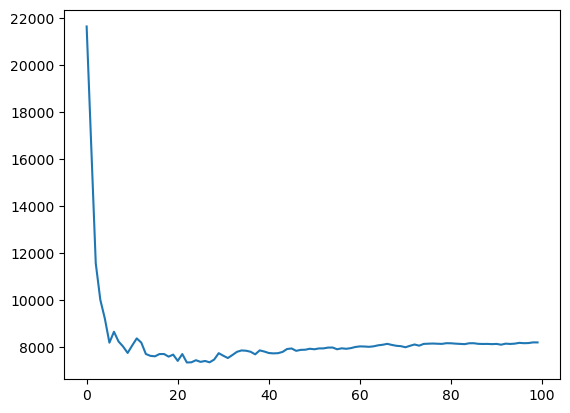

In [327]:
sns.lineplot(devs)

In [ ]:
rate_model = gbtmodel.model_state.rate_models[0]
rate_model.max_iter=rate_model.n_iter_ + 50; rate_model.verbose=True #rate_model.scoring = score_fn

lam_hat = np.exp(raw_predictions)
y_hat = lam_hat/lam_hat.sum()

init_score = -xlogy(y_nat, y_hat).sum()
init_score

141468.45186697287

In [ ]:
rate_model.fit(
    X, 
    y,
    sample_weight = sample_weight,
    raw_predictions = raw_predictions.reshape((-1,1)),
    svi_shrinkage = 1,
)

Binning 0.006 GB of training data: 0.010 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
[110/159] 1 tree, 29 leaves, max depth = 5, train loss: 0.16430, val loss: 0.16943, in 0.013s
[111/159] 1 tree, 30 leaves, max depth = 5, train loss: 0.16428, val loss: 0.16943, in 0.012s
[112/159] 1 tree, 30 leaves, max depth = 5, train loss: 0.16426, val loss: 0.16944, in 0.008s
[113/159] 1 tree, 27 leaves, max depth = 5, train loss: 0.16423, val loss: 0.16946, in 0.008s
Fit 113 trees in 0.095 s, (3466 total leaves)
Time spent computing histograms: 0.006s
Time spent finding best splits:  0.001s
Time spent applying splits:      0.009s
Time spent predicting:           0.001s


CustomHistGradientBooster(early_stopping=True, loss='poisson', max_depth=5,
                          max_iter=159, n_iter_no_change=3,
                          validation_fraction=0.2, verbose=True,
                          warm_start=True)

In [ ]:
def track_score(model, X, y, sample_weight = None):
    if sample_weight is None:
        sample_weight = np.ones_like(y)
    return score_fn(model, X, y*sample_weight)

reg = HistGradientBoostingRegressor(
    loss = 'poisson',
    scoring=track_score,
    verbose=True,
).fit(
    X,y_nat,
)


reg = PoissonRegressor(alpha=0, fit_intercept=False, verbose=True, solver = 'newton-cholesky').fit(X, y, sample_weight)

Binning 0.007 GB of training data: 

0.155 s
Binning 0.001 GB of validation data: 0.002 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, train score: 4462.76598, val score: 11991.17395, in 0.013s
[2/100] 1 tree, 31 leaves, max depth = 7, train score: 4422.95682, val score: 11897.66569, in 0.013s
[3/100] 1 tree, 31 leaves, max depth = 8, train score: 4394.20113, val score: 11829.12781, in 0.012s
[4/100] 1 tree, 31 leaves, max depth = 8, train score: 4371.47751, val score: 11775.07080, in 0.013s
[5/100] 1 tree, 31 leaves, max depth = 9, train score: 4352.55952, val score: 11731.37805, in 0.011s
[6/100] 1 tree, 31 leaves, max depth = 9, train score: 4337.38921, val score: 11696.02667, in 0.012s
[7/100] 1 tree, 31 leaves, max depth = 8, train score: 4325.00987, val score: 11666.25526, in 0.013s
[8/100] 1 tree, 31 leaves, max depth = 8, train score: 4314.44137, val score: 11641.84089, in 0.014s
[9/100] 1 tree, 31 leaves, max depth = 8, train score: 4305.44727, val score: 11620.60720, in 0.019s
[10/1

In [ ]:
rate_model.fit(
    X, y, sample_weight
)

TypeError: fit() takes 3 positional arguments but 4 were given

In [ ]:
init_score, score_fn(rate_model, X, y_nat)

(141468.45186697287, 141451.76568422644)

In [ ]:
model.mutation_rate_deviance(corpus1)

/Users/allenwlynch/projects/locusregression/signaturemodels/locusregression/corpus/corpus.py:358: RuntimeWarning: divide by zero encountered in log
  return np.log(mutation_rate) #- np.log(len(self))
/Users/allenwlynch/projects/locusregression/signaturemodels/locusregression/model/base.py:9: RuntimeWarning: invalid value encountered in divide
  y = y/y.sum(); y_hat = y_hat/y_hat.sum()


nan

In [ ]:
from locusregression.model.base import _dir_prior_update_step
from scipy.stats import dirichlet
import numpy as np

alpha = np.array([5,1,10,3,2])
gamma = dirichlet(alpha).rvs(100)
alpha_hat = np.ones_like(alpha)*1

logp = np.log(gamma).mean(0)

In [ ]:
alpha_hat = _dir_prior_update_step(alpha_hat, 100, logp)
alpha_hat

-586.851097804491 | -586.851097804491 | -586.851097804491 | -586.7057239617828 | 1.0


array([ 4.96631628,  1.02301537, 10.02216271,  2.98184636,  2.05222653])